# Connectum Embedded - Walk Creation Stategies

## Introduction
Neuroscience research has found that structural and functional brain connectivity (SC and FC, respectively) are typically only moderately correlated (~0.3), possibly due to higher order relations between brain nodes that cannot be captured by a simple comparison between functional and structural connectivity (Levakov, Faskowitz, Avidan & Sporns, 2021).

Connectome-embedding (CE) is a method for creating learned vectorized representations of brain nodes, while taking into account their context in the brain network topology. It has been shown to improve structural to functional connectivity mapping when it was trained using a data-set of randomly generated walks on the brain graph (Levakov, Faskowitz, Avidan & Sporns, 2021).
Although the walks for the data-set were randomly generated in past research, the exact mechanisms underpinning neural signals transformation in the brain are still unclear (Avena-Koenigsberger, Yan, Kolchinsky, van den Heuvel, Hagmann & Sporns, 2019).

One of the models that were suggested for neural signals transformation is a shortest-path strategy, in which the brain signals are travelling through the shortest possible path between the source node to the destination node (Avena-Koenigsberger, Misic & Sporns, 2018). This current research was conducted in order to check the effect of training CE models using data-set of brain walks that were generated using the shortest-path strategy or an in-between strategy that combines shortest-path and random walks. Previous research was supported by CEPY, a dedicated Python library for creating and training CE models. Therefore, this current research is based on the Cepy Python library and extanding it's walk-creation abilities.

## Shortest Path

### Introduction
This possible strategy suggest that neural information travels in the brain through the shortest possible path between the source of the signal to it's destination. In other terms, a signal will pass as few nodes as possible in it's way (Avena-Koenigsberger, Misic & Sporns, 2018).

This strategy is not likely to represent brain connectivity, since it would require the neural signals to posses the knowledge about the entire brain network topology (Avena-Koenigsberger, Misic & Sporns, 2018).
Despite that assessment, we still wanted to check how data-set of walks that was created using this strategy would affect the correlations between functional connectivity and CE's representation of structural connectivity. 

### Code Implementation
First, we import the Cepy module, ShortestPathGenerator module, and some other libraries that are important for this demonstration.

In [ ]:
import sys
print("Now installing cepy module and other depndencies, please wait until installation is done...")
!pip3 install -r requirements.txt
print("Installed all notebook's dependencies")

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from cepy import CE
import logging
from walks_creators.shortest_path_generator import ShortestPathGenerator
import sys
sys.path.append('./walk_strategies_utils')
import charts_creator  # <- Util for displaying charts of test results's CSV files

We'll define some basic parameters for the Cepy models that will be created and load the SC matrix using Numpy
> num_walks is set to 2 to save time in this demonstration, it should be set to at least 800 for better results

In [2]:
ce_parameters = {'dimensions': 30, 'walk_length': 20, 'num_walks': 2, 'window': 3, 'p': 0.1, 'q': 1.6,
                 'permutations': 100, 'workers': 10, 'verbosity': 2, 'seed': 2021}
sc_mat = np.load("data/sc_group_matrix.npz")['x']  # Loading the SC matrix using numpy

We'll now initialize a ShortestPathGenerator instance and generate shortest-path walks.

Parameters:
* **sc_mat_object**: np.ndarray - SC matrix.
* **walks_for_node**: int - Number of walks to be created for every source node in SC matrix. Default is 800.
> "walks_for_node" is set to 2 to save time in this demonstration, it should be set to at least 800 for better results

In [3]:
shortest_paths_generator = ShortestPathGenerator(sc_mat_object=sc_mat)  # Initializing ShortestPathGenerator instance
shortest_paths_generator.logger.setLevel(logging.INFO)  # To prevent logs overload in notebook
shortest_walks = shortest_paths_generator.generate_walks(walks_for_node=2)

2022-08-26,14:18:11 - INFO - Starting to generate walks
2022-08-26,14:18:23 - INFO - Shortest paths generator finished creating a total of 160000 walks after 11.89 seconds.
WALKS: 400, 2.0 per node


We will now initialize a Cepy intance and we will provide the walks that were previously generated using the new "pregenerated_walks" parameter. Then we'll train the CE model. 

> num_walks is set to 2 to save time in this demonstration, it should be set to at least 800 for better results

In [4]:
ce_model_shortest = CE(pregenerated_walks=shortest_walks, **ce_parameters)
ce_model_shortest.fit(sc_mat)
print("Done training model")

Start training  100  word2vec models on  10 threads.
Done training model


### Results
We will now create a lineplot using a CSV file that was generated in advance by comparing multiple subjects' SC-FC correlations using the raw SC, CE that was created using random walks or CE that ws created using shortest-path walks.

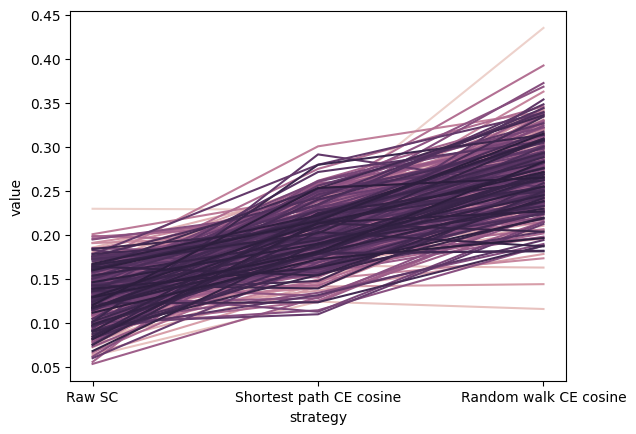

In [5]:
charts_creator.create_shortest_test_chart("./shortest_vs_random_test/data/shortest_vs_random_results.csv")

As we can see, the average spearman's correlation coefficient between FC and CE models that were trained using shortest-path walks was higher than the coefficient between raw SC and FC, but lower than the coefficient between FC and CE models that were trained using random walks.

## Global information tuner

### Introduction
The results for shortest-path strategy showed that randomly generated walks yield better FC-SC mapping than shortest-path walks, but we wanted to check whether a hybrid strategy, which combines shortest-path and random diffusion, can outperform the former two tested strategies.

We used a stochastic model which was introduced by Avena-Koenigsberger, Yan, Kolchinsky, van den Heuvel, Hagmann and Sporns (2019). This model defines a mathematical formula which represents the extent to which the brain signal route is biased by global information. In other words, using the variables in this formula, one can control brain walks dynamics, to make them more like random walks or more like shortest-path walks.

<div style="text-align: center">
<img src="https://i.postimg.cc/yNJBC70b/formula.png" width="400"/>
</div>

### Code Implementation
We'll import the GlobalInformationBiasTuner class.

In [6]:
from walks_creators.global_information_bias_tuner import GlobalInformationBiasTuner

We'll define some basic parameters for the Cepy models that will be created and load the SC matrix using Numpy
> num_walks is set to 2 to save time in this demonstration, it should be set to at least 800 for better results

In [7]:
ce_parameters = {'dimensions': 30, 'walk_length': 20, 'num_walks': 2, 'window': 3, 'p': 0.1, 'q': 1.6,
                 'permutations': 100, 'workers': 10, 'verbosity': 2, 'seed': 2021}
sc_mat = np.load("./data/sc_group_matrix.npz")['x']  # Loading the SC matrix using numpy

We'll now assign values for the relevant parameters to the stochastic model's walks creator:
* **proximity_matrix**: np.ndarray - SC matrix.
* **lambda_value**: float - Used by the stochastic model's formula. It controls the extent to which a walk is biased by global information. Low values will yield random walks, high values will yield shortest-path walks.
* **community_bias_value**: float - Used by our module to determine which node is the current walk's target. If the target is reached before the walk had achieved it's desired length, a new node is sampled as the target. Low values will yield walks that remain inside their "community", high values will yield walks that explore outside their "community".
* **walks_for_node**: int - number of walks to be created for each source node in proximity_matrix.
* **n_threads**: int - number of threads that will be used to create walks. If set to less than 4, the class will only use one thread, as the expected time to manage the threads will be longer than the cost of using only one thread.

In [8]:
global_info_bias_tuner = GlobalInformationBiasTuner(
    proximity_matrix=sc_mat,
    walks_for_node=1,
    lambda_value=1,
    community_bias_value=1,
    n_threads=8
)
stochastic_walks = global_info_bias_tuner.generate_walks()

2022-08-26,14:21:56 - INFO - Global Information Bias Tuner - Starting to create 1 walks for each node with given values: Lambda value 1, Community Bias Value 1
Generating walks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:12<00:00, 16.09it/s]


We will now initialize a Cepy intance and we will provide the walks that were previously generated using the new "pregenerated_walks" parameter. Then we'll train the CE model. 

> num_walks is set to 2 to save time in this demonstration, it should be set to at least 800 for better results

In [9]:
# ce_model_shortest = CE(dimensions=30, walk_length=20, permutations=1, num_walks=2, save_walks=True, pregenerated_walks=walks)
ce_model_shortest = CE(pregenerated_walks=stochastic_walks, **ce_parameters)
ce_model_shortest.fit(sc_mat)
print("Done training model")

Start training  100  word2vec models on  10 threads.
Done training model


### Results
We will now create a lineplot using a CSV file that was generated in advance by comparing SC-FC correlations by creating multiple CE models that were trained using different data-sets of generated walks, created using different community bias values and different lambda values.

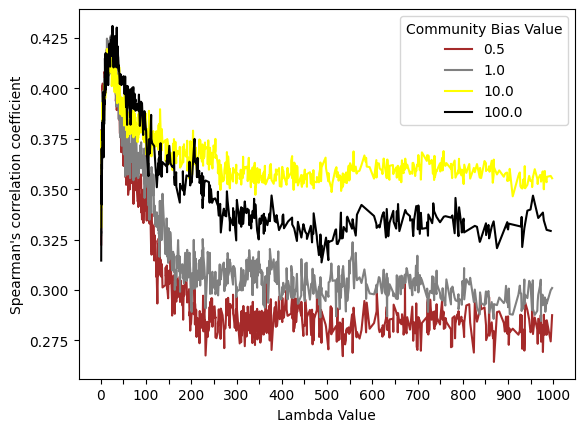

In [10]:
charts_creator.create_lambda_test_chart("./lambda_value_test/data/lambda_test_results.csv")

After going finding the effective ranges of lambda and comminuty bias values, and then going through many combinations of the two values, it has been found that walks that are created using a lambda value of 50 and community bias value of 100 are yielding CE models that have the best correlations to FC, peaking at about 0.42.

These walks resemble random walks more than shortest-path walks, but they are not completely random.

## Strategies comparison for consensus matrix
Another tool was written in order to easily compare between the strategies. It loads a "consensus" FC and SC matrices that represents the average brain network typology and checks the correlation between the two. Afterwards, it created a CE model while taking into account the given strategy and parameters to create the walks that will be used as a data-set for the model. It then shows the resulting correlation between CE and FC.

### Code implementation

We'll now import the comparison tool, load FC and SC matrices and provide them to the tool.

In [11]:
import sys
sys.path.append('./walk_strategies_utils')
from compare_consensus_correlations import compare_consensus_correlations
sc_mat_consensus = np.load(f"./data/sc_consensus_125.npy")
fc_mat_consensus = np.load(f"./data/fc_consensus_125.npy")

We'll store the params that should be provided to the walks creator of the desired type. I.E. for stochastic walks, "lambda_value" and "community_bias_value" should be given.

In [12]:
strategy_params = {"lambda_value": 50, "community_bias_value": 100, "walks_for_node": 1}  # For stochastic


We'll now run the comparison tool.

Params:
* **sc_mat_consensus** (Optional) - numpy ndarray - SC consensus. If not given, the tool will try to load the default matrix.
* **fc_mat_consensus** (Optional) - numpy ndarray - FC consensus. If not given, the tool will try to load the default matrix.
* **strategy** (Optional) - Str - Either "shortest", "stochastic" or "random". If no strategy is given, uses "random".
* **strategy_params** (Optional) - Dict - dictionary of params for desired strategy. For details about possible params, check the walks creator documentation.

In [13]:
res = compare_consensus_correlations(sc_mat_consensus=sc_mat_consensus, fc_mat_consensus=fc_mat_consensus, strategy="stochastic", strategy_params=strategy_params)  # For stochastic
print(res)

Starting to compare SC-FC correlations between regular and CE. Strategy: stochastic
2022-08-26,14:22:39 - INFO - Global Information Bias Tuner - Starting to create 1 walks for each node with given values: Lambda value 50, Community Bias Value 100
Generating walks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 233/233 [00:15<00:00, 15.17it/s]
Creating CE model using consensus matrix
Start training  100  word2vec models on  10 threads.
Baseline: r=0.23, p=0.0, CE: r=-0.04 p=0.01
{'baseline': {'r': 0.2294151584916634, 'p': 1.8419677239139747e-46}, 'ce': {'r': -0.04480520384171679, 'p': 0.005794635826661581}}


### references

* https://github.com/GidLev/cepy (source for Connectum Embedded code)
* Avena-Koenigsberger, A., Yan, X., Kolchinsky, A., van den Heuvel, M. P., Hagmann, P., & Sporns, O. (2019). A spectrum of routing strategies for brain networks. PLoS computational biology, 15(3), e1006833.‏
* Avena-Koenigsberger, A., Misic, B., & Sporns, O. (2018). Communication dynamics in complex brain networks. Nature reviews neuroscience, 19(1), 17-33.‏
* Levakov, G., Faskowitz, J., Avidan, G., & Sporns, O. (2021). Mapping individual differences across brain network structure to function and behavior with connectome embedding. Neuroimage, 242, 118469.‏